# Perturbation Methods

In [93]:
import numpy as np
import scipy.optimize as opt
import scipy.stats
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp
import matplotlib.pyplot as plt
import sympy as sy
from sympy.utilities.lambdify import lambdify

## Exercise 1

Please refer to pdf in the same repository.

## Exercise 2

In [94]:
def excess_demand(w, mparams):
    (alpha, z, b, t, h, k) = mparams
    nd = ((1 - alpha) * z / w) ** (1 / alpha) * k
    profit = z * k ** alpha * nd ** (1 - alpha) - w * nd
    ns = h - b / (w * (1 + b)) * (w * h + profit - t)
    return nd - ns

In [101]:
alpha = 0.33
z = 1
b = 2
t = 0.1
h = 24
k = 10 ### Approximating around k = 5
mparams = np.array([alpha, z, b, t, h, k])

### Market Clearing Wage

In [102]:
w = opt.fsolve(excess_demand, 0.8, args = mparams)[0]
print(w)

0.7893033338962346


In [103]:
def first_deriv(f, x0, h=1e-8):
    return (f(x0 + h) - f(x0 - h)) / (2 * h)

def second_deriv(f, x0, h=1e-2):
    return (f(x0 + h) + f(x0 - h) - 2 * f(x0)) / (h ** 2)

def first_approx(f, x0, x):
    fp = first_deriv(f, x0)
    return f(x0) + fp * (x - x0)

def second_approx(f, x0, x):
    fp = first_deriv(f, x0)
    fpp = second_deriv(f, x0)
    return f(x0) + fp * (x - x0) + (1/2) * fpp * (x - x0) ** 2

In [111]:
def get_ss_w(k1, w_guess=0.8):
    args = np.array([alpha, z, b, t, h, k1])
    return opt.fsolve(excess_demand, w_guess, args = args)[0]

In [115]:
def plot_approx_k(k0):
    
    kgrid = np.linspace(1, 15, 15)
    wgrid_true = np.zeros_like(kgrid)
    wgrid_1order = np.zeros_like(kgrid)
    wgrid_2order = np.zeros_like(kgrid)

    for i in range(len(kgrid)):
        wgrid_true[i] = get_ss_w(kgrid[i], 0.5)
        wgrid_1order[i] = first_approx(get_ss_w, k0, kgrid[i]) 
        wgrid_2order[i] = second_approx(get_ss_w, k0, kgrid[i])

    fig = plt.figure(figsize=(6,6))
    plt.plot(kgrid, wgrid_true, label='Exact')
    plt.plot(kgrid, wgrid_1order, label='1st')
    plt.plot(kgrid, wgrid_2order, label ='2nd')
    plt.legend()
    plt.xlabel('Capital')
    plt.ylabel('Wage')
    plt.title("Approximation to Wage Policy Function")
    plt.grid()
    plt.show()

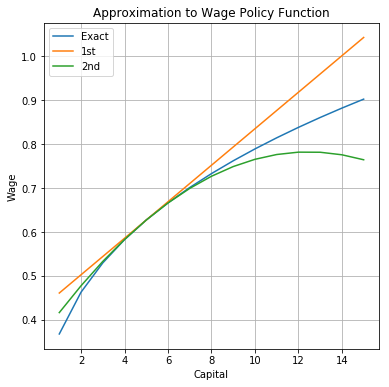

In [116]:
plot_approx_k(5)

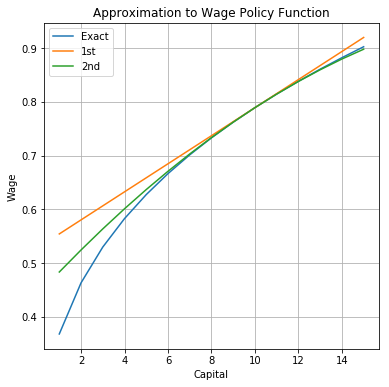

In [117]:
plot_approx_k(10)

### Bivariate Numerical Derivative Method (Grid)

In [14]:
def Bnumdiff3(f, y0, x0, eps):

    # function evaluations
    fA = f(y0+2*eps, x0-eps)
    fB = f(y0+2*eps, x0)
    fC = f(y0+2*eps, x0+eps)
    fD = f(y0+eps, x0-2*eps)
    fE = f(y0+eps, x0-eps)
    fF = f(y0+eps, x0)
    fG = f(y0+eps, x0+eps)
    fH = f(y0+eps, x0+2*eps)
    fI = f(y0, x0-2*eps)
    fJ = f(y0, x0-eps)
    fK = f(y0, x0)
    fL = f(y0, x0+eps)
    fM = f(y0, x0+2*eps)
    fN = f(y0-eps, x0-2*eps)
    fP = f(y0-eps, x0-eps)
    fQ = f(y0-eps, x0)
    fR = f(y0-eps, x0+eps)
    fS = f(y0-eps, x0+2*eps)
    fT = f(y0-2*eps, x0-eps)
    fU = f(y0-2*eps, x0)
    fV = f(y0-2*eps, x0+eps)
    
    # numerical derivatives
    fx = (fL-fJ) / (2*eps)
    fy = (fF-fQ) / (2*eps)
    fxx = (fL-2*fK+fJ) / (eps**2)
    fyy = (fF-2*fK+fQ) / (eps**2)
    fxy = (fG-fE-fR+fP) / (4*eps**2)
    fxxx = (fM-2*fL+2*fJ-fI) / (2*eps**3)
    fxxy = (fH-2*fF-fS+fD+2*fQ-fN) / (8*eps)
    fxyy = (fA-2*fJ-fC+fT+2*fL-fV) / (8*eps)
    fyyy = (fB - 2*fF + 2*fQ - fU) / (2*eps**3)
    
    return fx, fy, fxx, fxy, fyy, fxxx, fxxy, fxyy, fyyy

In [15]:
def get_coeff(fx, fy, fxx, fxy, fyy, fxxx, fxxy, fxyy, fyyy):
    
    w1 = -fx / fy
    w2 = -(fyy*w1**2 + 2*fxy*w1 + fxx) / fy
    w3 = -(fyy*w1**3 + 3*fyy*w2*w1 + 2*fxy*w2 + 2*fxyy*w1**2 + fxxx) / fy
    
    return w1, w2, w3

In [25]:
def approx(y0, x0, x, w1, w2, w3):
    
    fo_approx = y0 + w1*(x - x0)
    so_approx = fo_approx + .5*w2*(x - x0)**2
    to_approx = so_approx + (1/6)*w3*(x - x0)**3
    
    return fo_approx, so_approx, to_approx

Following code follows Dr. Phillips' sample code:

w0:  [0.68771628]
check:  [-8.8817842e-16]


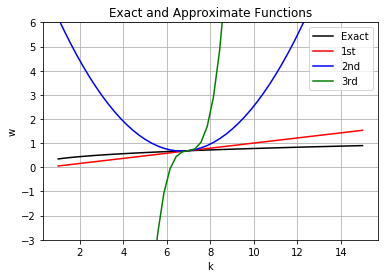

In [90]:
# choose approximation point
k0 = 7.
params = np.array([alpha, z, b, t, h, k0])

#  create anonymous function
f = lambda w: excess_demand(w, params)

#  use fsolve to find equlibrium wage
w0 = opt.fsolve(f, .1)
print ('w0: ', w0)

#  check solution
check = excess_demand(w0, params)
print ('check: ', check)

# get derivatives from numerical differentiator
fx, fy, fxx, fxy, fyy, fxxx, fxxy, fxyy, fyyy = \
    Bnumdiff3(excess_demand, w0, params, eps);
    
# get coefficients using perturbation formulas
w1, w2, w3 = get_coeff(fx, fy, fxx, fxy, fyy, fxxx, fxxy, fxyy, fyyy)

# set up a grid
min = 1
max = 15
nstep = 50
kgrid = np.linspace(min, max, num=nstep)
wgrid = np.zeros(nstep)
w1grid = np.zeros(nstep)
w2grid = np.zeros(nstep)
w3grid = np.zeros(nstep)

#  get solutions at each point on the grid
for i in range(0, nstep):
    
    # find exact solutions
    # create anonymous function
    params = np.array([alpha, z, b, t, h, kgrid[i]])
    f = lambda w: excess_demand(w, params)
    # use fsolve to find equilibrium wage
    wgrid[i] = opt.fsolve(f, .1)
    
    # evaluate approximations 
    fo_approx, so_approx, to_approx = approx(w0, k0, kgrid[i], w1, w2, w3)
    w1grid[i] = fo_approx
    w2grid[i] = so_approx
    w3grid[i] = to_approx

# plot results
plt.plot(kgrid, wgrid, 'k-',
         kgrid, w1grid, 'r-',
         kgrid, w2grid, 'b-',
         kgrid, w3grid, 'g-')
plt.legend(['Exact', '1st', '2nd', '3rd'], loc=1)
plt.title('Exact and Approximate Functions')
plt.xlabel('k')
plt.ylabel('w')
plt.ylim(bottom=-3, top=6)
plt.grid()
plt.show()    

## Exercise 3

$$F(y, x)=\left(x^{35}+.9 x-y\right)^{-2.5}-.95\left(y^{35}+.9 y\right)^{-2.5}=0$$

In [30]:
def func3(y, x):
    return (x ** .35 + .9 * x - y) ** -2.5 - .95 * (y **.35 + .9 * y) ** -2.5

y0:  [47.46578754]
check:  [-2.24971951e-18]


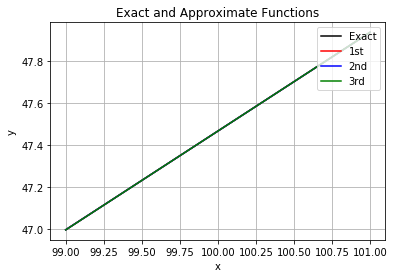

In [89]:
# choose approximation point
x0 = 100

# set value for epsilon
eps = .01

#  create anonymous function
f = lambda y: func3(y, x0)  

#  use fsolve to find equlibrium wage
y0 = opt.fsolve(f, .1)
print ('y0: ', y0)

#  check solution
check = func3(y0, x0)  
print ('check: ', check)

# get derivatives from numerical differentiator
fx, fy, fxx, fxy, fyy, fxxx, fxxy, fxyy, fyyy = \
    Bnumdiff3(func3, y0, x0, eps);
    
# get coefficients using perturbation formulas
w1, w2, w3 = get_coeff(fx, fy, fxx, fxy, fyy, fxxx, fxxy, fxyy, fyyy)

# set up a grid
min = 99
max = 101
nstep = 50
xgrid = np.linspace(min, max, num=nstep)
ygrid = np.zeros(nstep)
y1grid = np.zeros(nstep)
y2grid = np.zeros(nstep)
y3grid = np.zeros(nstep)

#  get solutions at each point on the grid
for i in range(0, nstep):
    
    # find exact solutions
    # use fsolve to find equilibrium y
    f = lambda y: func3(y, xgrid[i])
    ygrid[i] = opt.fsolve(f, .1)
    
    # evaluate approximations 
    fo_approx, so_approx, to_approx = approx(y0, x0, xgrid[i], w1, w2, w3)
    y1grid[i] = fo_approx
    y2grid[i] = so_approx
    y3grid[i] = to_approx

# plot results
plt.plot(xgrid, ygrid, 'k-',
         xgrid, y1grid, 'r-',
         xgrid, y2grid, 'b-',
         xgrid, y3grid, 'g-')
plt.legend(['Exact', '1st', '2nd', '3rd'], loc=1)
plt.title('Exact and Approximate Functions')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

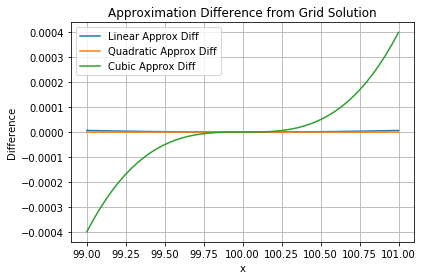

In [88]:
# Approximation difference from grid solution
plt.plot(xgrid, y1grid - ygrid, label='Linear Approx Diff')
plt.plot(xgrid, y2grid - ygrid, label='Quadratic Approx Diff')
plt.plot(xgrid, y3grid - ygrid, label='Cubic Approx Diff')
plt.legend()
plt.xlabel('x')
plt.ylabel(r'Difference')
plt.title('Approximation Difference from Grid Solution')
plt.grid()
plt.tight_layout()
plt.show()

## Exercise 4

In [120]:
alpha = 0.35
beta = 0.98
kbar = (alpha * beta) ** ( 1 / (1 - alpha) )

In [121]:
y, x, u = sy.symbols('y x u')
f = 1 / (u**alpha-x) - beta * ( alpha*x**(alpha-1) ) / (x**alpha-y)

In [122]:
fx = sy.diff(f, x)
fy = sy.diff(f, y)
fu = sy.diff(f, u)
fxx = sy.diff(fx, x)
fxy = sy.diff(fx, y)
fyy = sy.diff(fx, y)
fxu = sy.diff(fx, u)
fyu = sy.diff(fy, u)
fuu = sy.diff(fu, u)
fx = lambdify((y, x, u), fx, 'numpy')
fy = lambdify((y, x, u), fy, 'numpy')
fu = lambdify((y, x, u), fu, 'numpy')
fxx = lambdify((y, x, u), fxx, 'numpy')
fxy = lambdify((y, x, u), fxy, 'numpy')
fyy = lambdify((y, x, u), fyy, 'numpy')
fxu = lambdify((y, x, u), fxu, 'numpy')
fyu = lambdify((y, x, u), fyu, 'numpy')
fuu = lambdify((y, x, u), fuu, 'numpy')

In [123]:
fx = fx(kbar, kbar, kbar)
fy = fy(kbar, kbar, kbar)
fu = fu(kbar, kbar, kbar)
fxx = fxx(kbar, kbar, kbar)
fxy = fxy(kbar, kbar, kbar)
fyy = fyy(kbar, kbar, kbar)
fxu = fxu(kbar, kbar, kbar)
fyu = fyu(kbar, kbar, kbar)
fuu = fuu(kbar, kbar, kbar)

In [124]:
xu = sy.symbols('xu')
xu = sy.solve(fy * xu**2 + fx*xu + fu, xu)
xu = xu[0]
print('Hx = ', xu)

Hx =  0.350000000000001


In [125]:
xuu = -(fyy*xu**4+2*fxy*xu**3+2*fyu*xu**2+fxx*xu**2+2*fxu*xu+fuu)/(fy*xu**2+fy*xu+fx)
print('Hxx = ', xuu)

Hxx =  -1.25699606856476


#### Policy Function

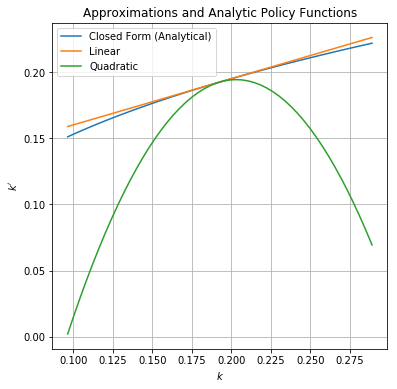

In [127]:
def analytic(k):
    return alpha * beta * (k ** alpha)

def linear_approx(k, kbar, xu):
    return kbar + kbar * xu * ((k - kbar) / kbar) 

def quad_approx(k, kbar, xu, xuu):
    return kbar + kbar * xu * ((k-kbar) / kbar) + 0.5 * xuu * ((k-kbar) / kbar) ** 2 

kmin = 0.5 * kbar
kmax = 1.5 * kbar
nsteps = 50
kGrid = np.linspace(kmin, kmax, nsteps)

fig = plt.figure(figsize=(6, 6))
plt.plot(kGrid, analytic(kGrid), label='Closed Form (Analytical)')
plt.plot(kGrid, linear_approx(kGrid, kbar, xu), label='Linear')
plt.plot(kGrid, quad_approx(kGrid, kbar, xu, xuu), label='Quadratic')
plt.title('Approximations and Analytic Policy Functions')
plt.grid()
plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$k'$")
plt.show()